In [4]:
!pip install keras-hypetune

In [5]:
import numpy as np
import pandas as pd
import os
import random
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
register_matplotlib_converters()

from statsmodels.tsa.vector_ar.var_model import VAR

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from kerashypetune import KerasRandomSearch

In [7]:
### READ DATA ###

df = pd.read_csv('AirQualityUCI.csv', sep=';', parse_dates={'date':['Date', 'Time']})
df.dropna(axis=1, inplace=True, how='all')
df.dropna(inplace=True)

df['date'] = pd.to_datetime(df.date , format = '%d/%m/%Y %H.%M.%S')
date = df['date'].values
df.set_index('date', inplace=True)

df.columns = [col.split('(')[0] for col in df.columns]

print(df.shape)
df.head()

(9357, 13)


,CO,PT08.S1,NMHC,C6H6,PT08.S2,NOx,PT08.S3,NO2,PT08.S4,PT08.S5,T,RH,AH
date,,,,,,,,,,,,,
2004-03-10 18:00:00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
2004-03-10 19:00:00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2004-03-10 20:00:00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
2004-03-10 21:00:00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
2004-03-10 22:00:00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


In [8]:
### ADJUST AND CLEAN DATA ###

df_external = pd.DataFrame(df.index)

for col in df.columns:
    
    if df[col].dtype == object: # correct type
        df[col] = pd.to_numeric(df[col].str.replace(',', '.'))
    
    df[col] = df[col].replace(-200, np.nan) # check nans
    print(col, ':', df[col].isna().sum()/len(df))
    if df[col][:int(len(df)*0.8)].isna().sum()/int(len(df)*0.8) > 0.5: # at least 50% in train not nan
        df.drop(col, axis=1, inplace=True)
    else:
        df[col] = df[col].interpolate(method='linear', limit_direction='both') # fill nans
        
    if col in ['T','RH','AH']:
        df_external[col] = df[col].values
        df.drop(col, axis=1, inplace=True)

CO : 0.17986534145559474
PT08.S1 : 0.0391151009939083
NMHC : 0.9023191193758683
C6H6 : 0.0391151009939083
PT08.S2 : 0.0391151009939083
NOx : 0.17516297958747462
PT08.S3 : 0.0391151009939083
NO2 : 0.1754835951693919
PT08.S4 : 0.0391151009939083
PT08.S5 : 0.0391151009939083
T : 0.0391151009939083
RH : 0.0391151009939083
AH : 0.0391151009939083


In [9]:
### UTILITY FUNCTION FOR CYCLICAL ENCODE VARIABLES ###

def cycle_encode(data, cols):
    
    for col in cols:
        
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())
        
    return data

In [10]:
### BUILD DATAFRAME OF EXTERNAL VARIABLES ###

df_external['month'] = df_external.date.dt.month
df_external['day'] = df_external.date.dt.dayofweek
df_external['hour'] = df_external.date.dt.hour

df_external = cycle_encode(df_external, ['month','day','hour'])
df_external.drop(['month','day','hour'], axis=1, inplace=True)
df_external.set_index('date', inplace=True)

print(df_external.shape)
df_external.head()

(9357, 9)


,T,RH,AH,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
date,,,,,,,,,
2004-03-10 18:00:00,13.6,48.9,0.7578,1.0,6.123234e-17,0.866025,-0.5,-0.979084,0.203456
2004-03-10 19:00:00,13.3,47.7,0.7255,1.0,6.123234e-17,0.866025,-0.5,-0.887885,0.460065
2004-03-10 20:00:00,11.9,54.0,0.7502,1.0,6.123234e-17,0.866025,-0.5,-0.730836,0.682553
2004-03-10 21:00:00,11.0,60.0,0.7867,1.0,6.123234e-17,0.866025,-0.5,-0.519584,0.854419
2004-03-10 22:00:00,11.2,59.6,0.7888,1.0,6.123234e-17,0.866025,-0.5,-0.269797,0.962917


In [11]:
### SPLIT TRAIN TEST ###

train, test = train_test_split(df, shuffle=False, train_size=0.8)

print(train.shape, test.shape)

(7485, 9) (1872, 9)


In [12]:
### PLOTTING UTILITY FUNCTIONS ###

def plot_sensor(name):
    
    plt.figure(figsize=(16,4))

    plt.plot(train.index, train[name], label='train')
    plt.plot(test.index, test[name], label='test')
    plt.ylabel(name); plt.legend()
    plt.show()
    
def plot_autocor(name, df):
    
    plt.figure(figsize=(16,4))
    
    # pd.plotting.autocorrelation_plot(df[name])
    # plt.title(name)
    # plt.show()
    
    timeLags = np.arange(1,100*24)
    plt.plot([df[name].autocorr(dt) for dt in timeLags])
    plt.title(name); plt.ylabel('autocorr'); plt.xlabel('time lags')
    plt.show()

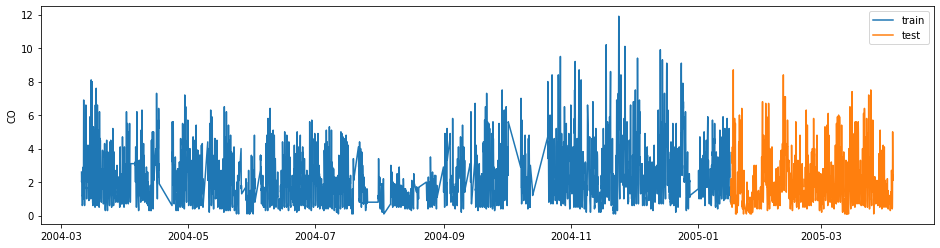

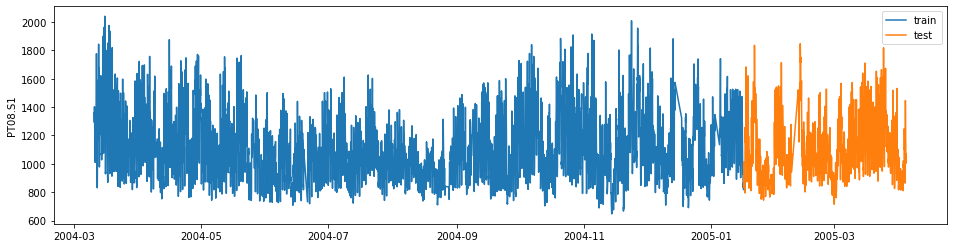

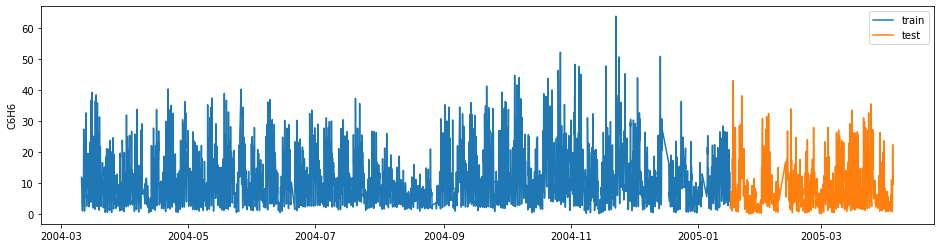

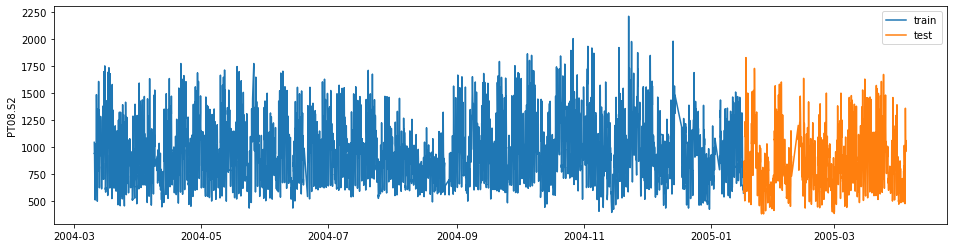

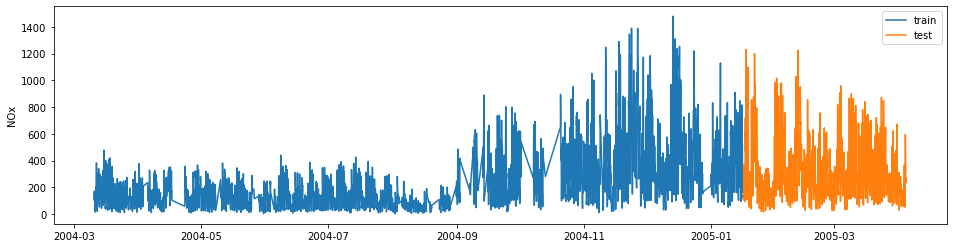

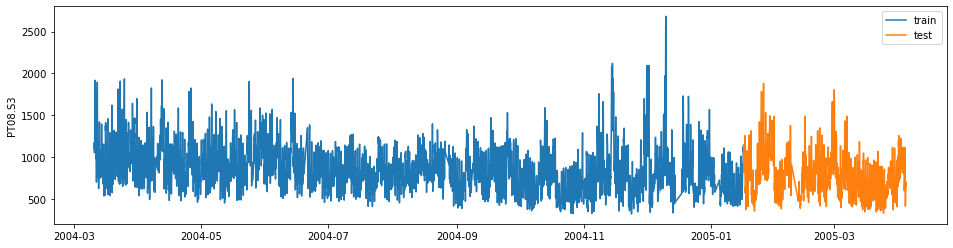

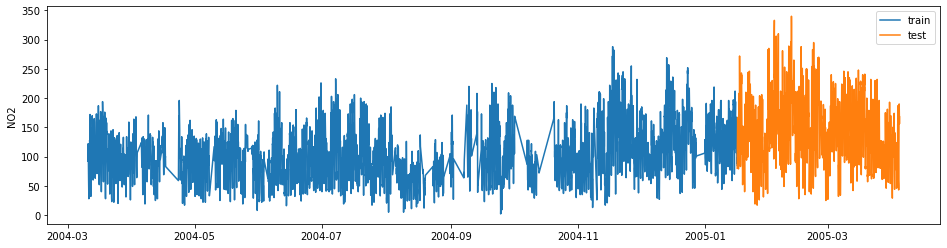

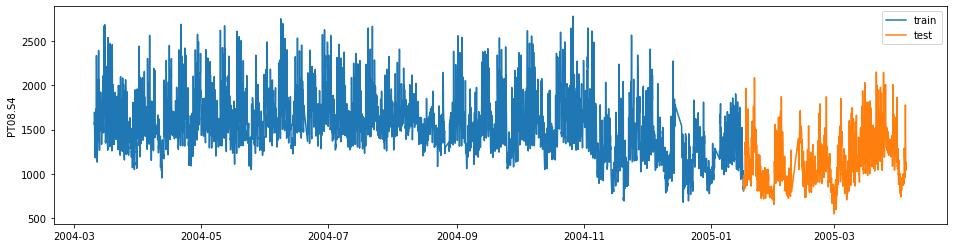

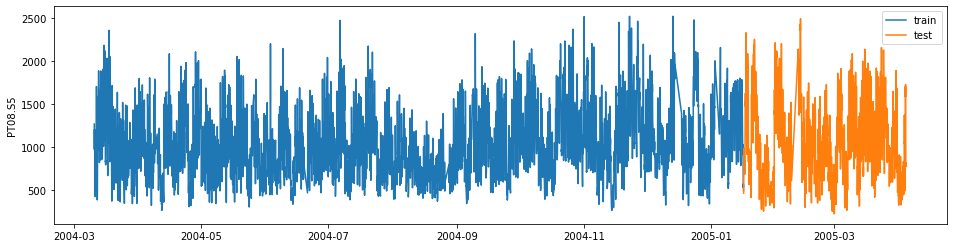

In [13]:
### PLOT ORIGINAL SERIES ###

for col in df.columns:
    plot_sensor(col)

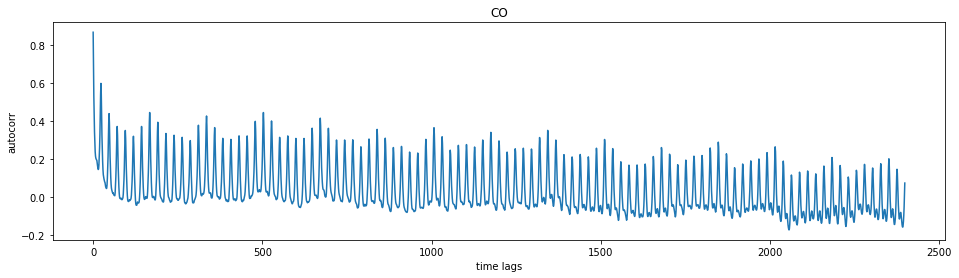

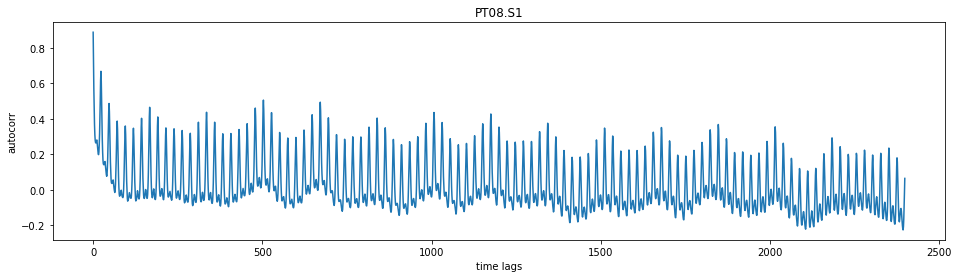

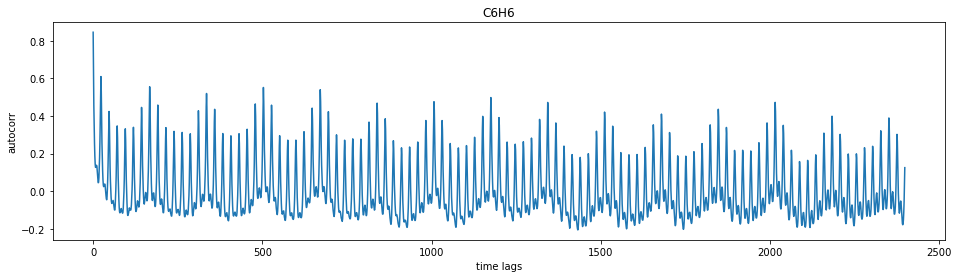

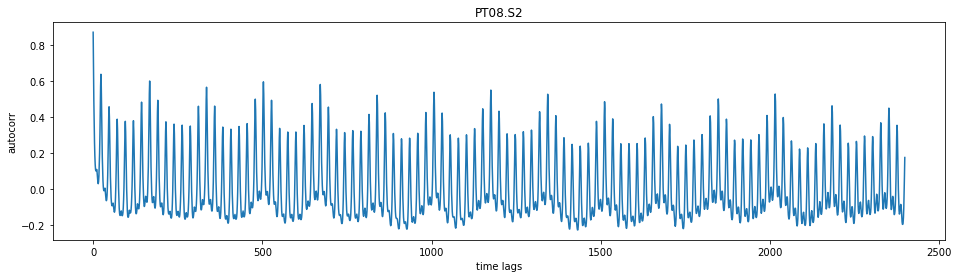

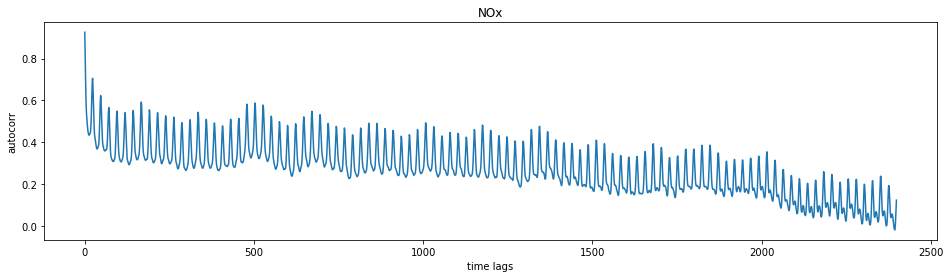

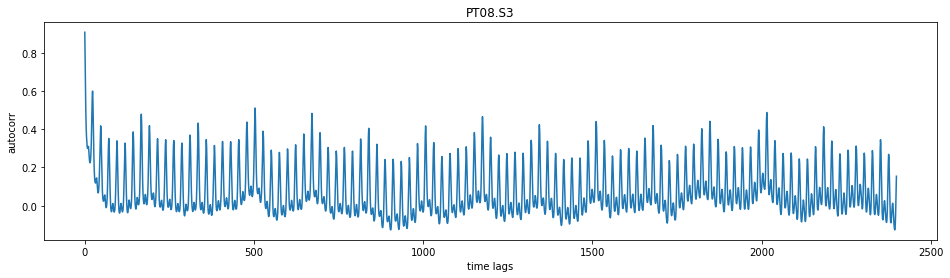

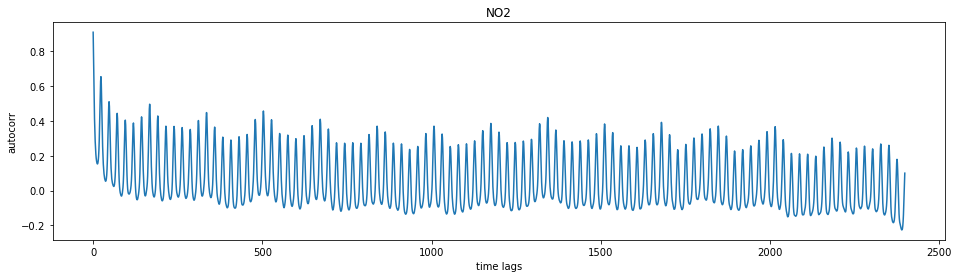

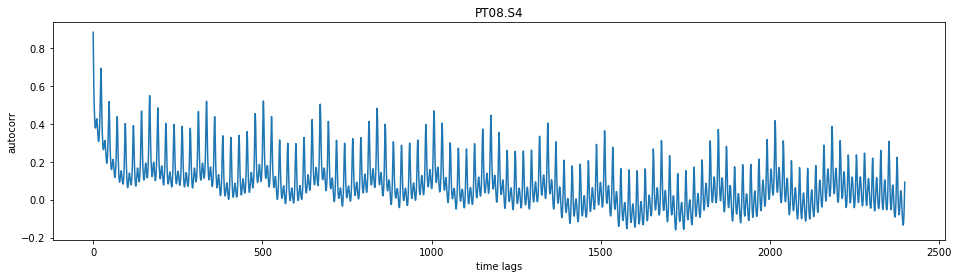

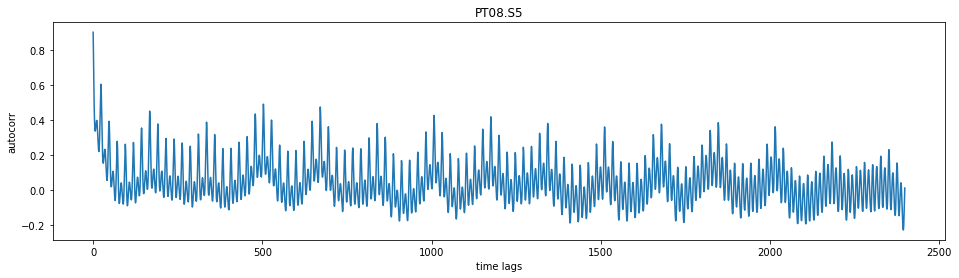

In [14]:
### PLOT AUTOCORRELATION ###

for col in df.columns:
    plot_autocor(col, train)

In [15]:
### OPERATE DIFFERENTIATION ###

period = 24*7

df_diff = df.diff(period).dropna()
df_external = df_external.iloc[period:].copy()

In [16]:
### SPLIT DIFFERENTIAL DATA IN TRAIN AND TEST ###

train_diff = df_diff.iloc[:len(train)-period,:].copy()
test_diff = df_diff.iloc[len(train)-period:,:].copy()

train_init = df.iloc[:len(train)-period,:].copy()
test_init = df.iloc[len(train)-period:-period,:].copy()

train_ext = df_external.iloc[:len(train)-period,:].copy()
test_ext = df_external.iloc[len(train)-period:,:].copy()

print(train_diff.shape, train_init.shape, train_ext.shape)
print(test_diff.shape, test_init.shape, test_ext.shape)

(7317, 9) (7317, 9) (7317, 9)
(1872, 9) (1872, 9) (1872, 9)


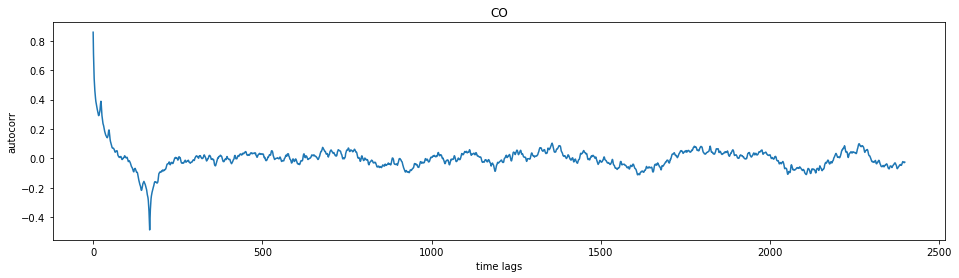

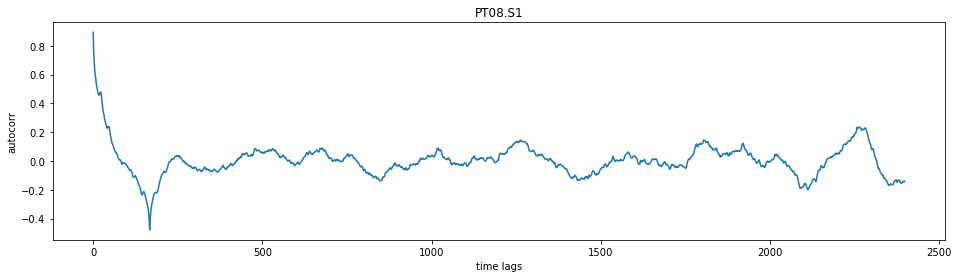

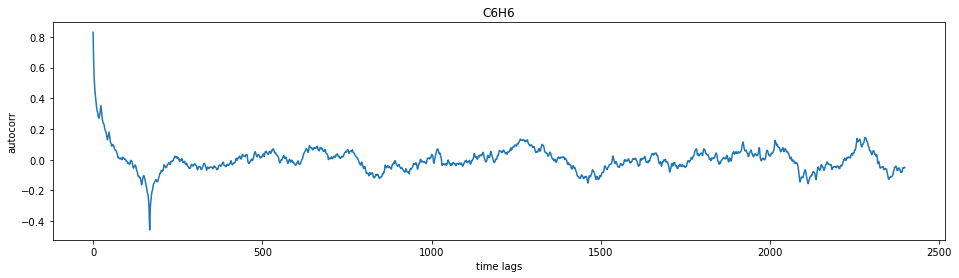

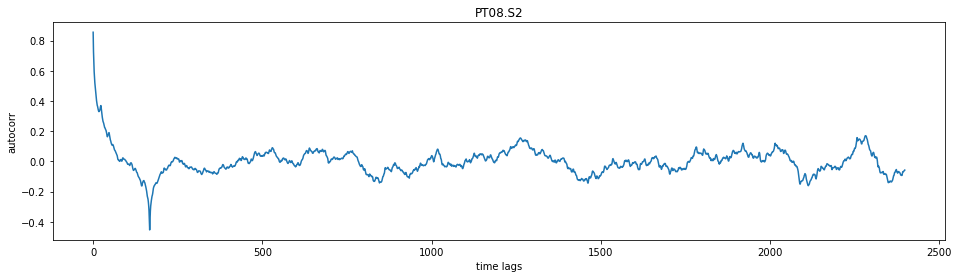

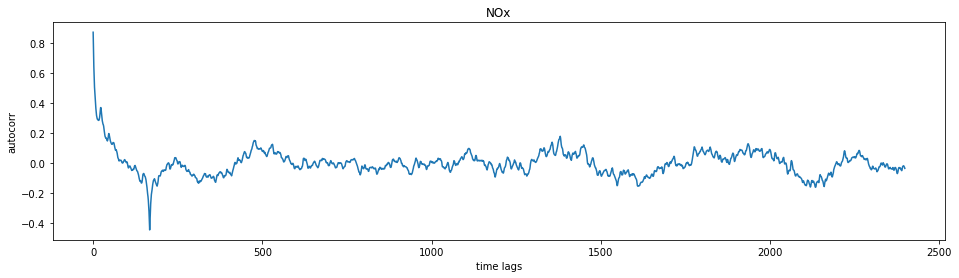

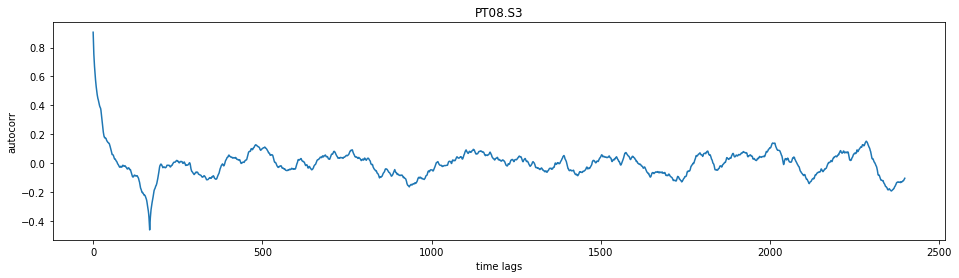

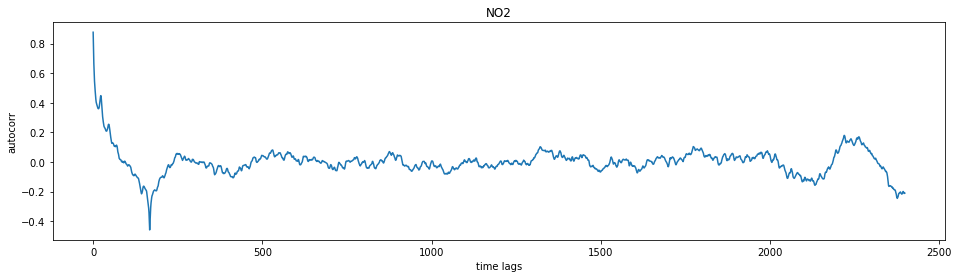

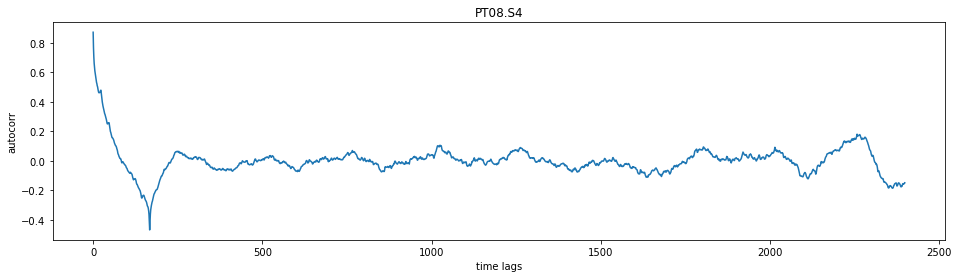

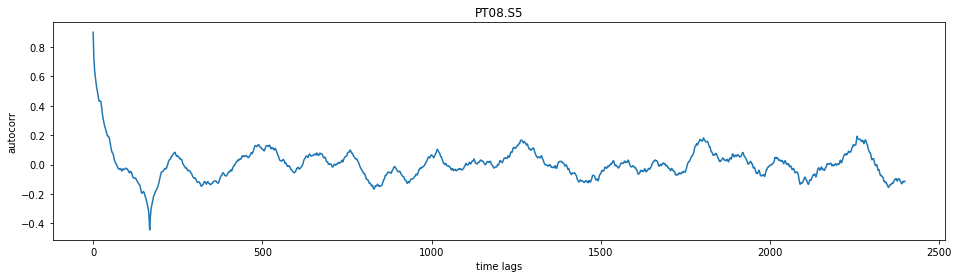

In [17]:
### PLOT DIFFERENTIAL SERIES ###

for col in df.columns:
    plot_autocor(col, train_diff)

In [18]:
### FIND BEST VAR ORDER ###

AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1,50):
    model = VAR(endog=train_diff.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

BEST ORDER 28 BEST AIC: 53.235108369896935


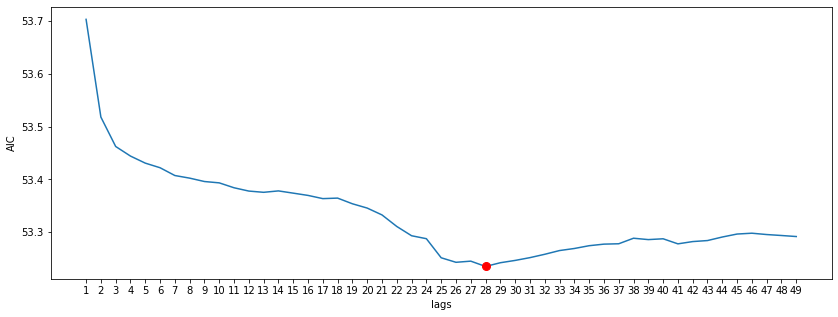

In [19]:
### PLOT AICs ### 

plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(len(AIC)), range(1,50))
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

In [20]:
### FIT FINAL VAR WITH LAG CORRESPONTING TO THE BEST AIC ###

var = VAR(endog=train_diff.values)
var_result = var.fit(maxlags=best_order)
var_result.aic

53.235108369896935

# VAR LONG-TERM PREDICTION

In [21]:
### UTILITY FUNCTION FOR RETRIVE VAR PREDICTIONS ###

def retrive_prediction(prior, prior_init, steps):
    
    pred = var_result.forecast(np.asarray(prior), steps=steps)
    init = prior_init.tail(period).values
    
    if steps > period:
        id_period = list(range(period))*(steps//period)
        id_period = id_period + list(range(steps-len(id_period)))
    else:
        id_period = list(range(steps))
    
    final_pred = np.zeros((steps, prior.shape[1]))
    for j, (i,p) in enumerate(zip(id_period, pred)):
        final_pred[j] = init[i]+p
        init[i] = init[i]+p    
        
    return final_pred

In [22]:
### RETRIVE PREDICTION AND OBTAIN THE CORRESPONDING ACTUAL VALUES ###

date = '2005-03-07 14:00:00'
forward = 100
date_range = pd.date_range(date, periods=forward+1, freq='H', closed='right')

final_pred = retrive_prediction(df_diff.loc[:date], df.loc[:date], steps = forward)
final_true = df.loc[date_range]

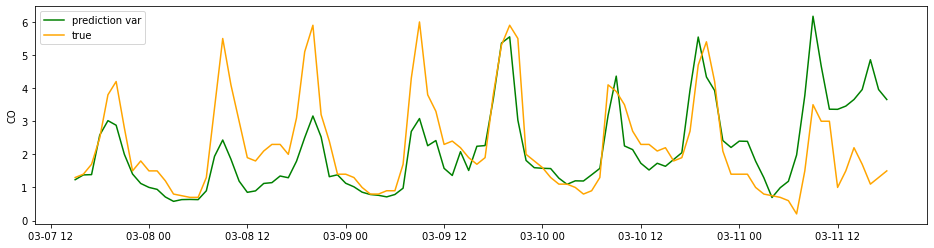

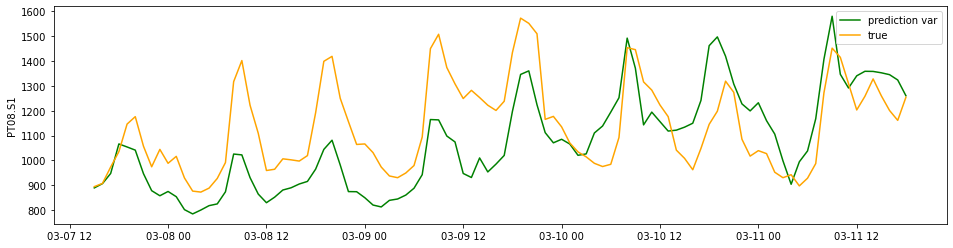

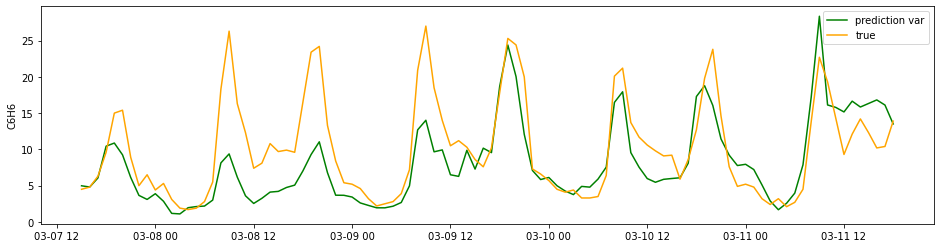

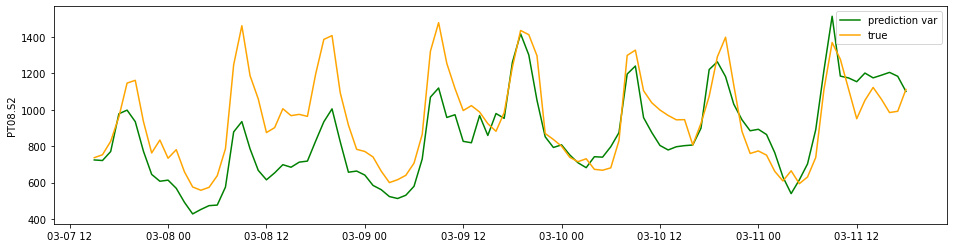

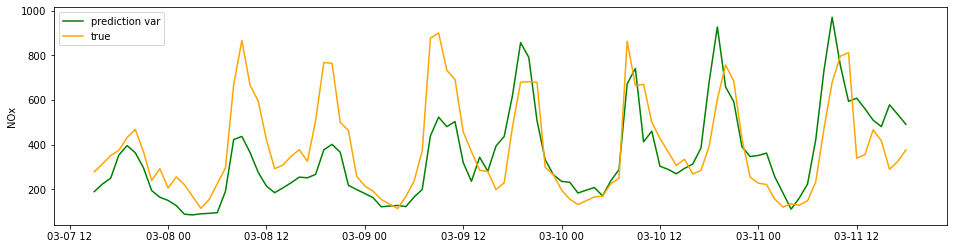

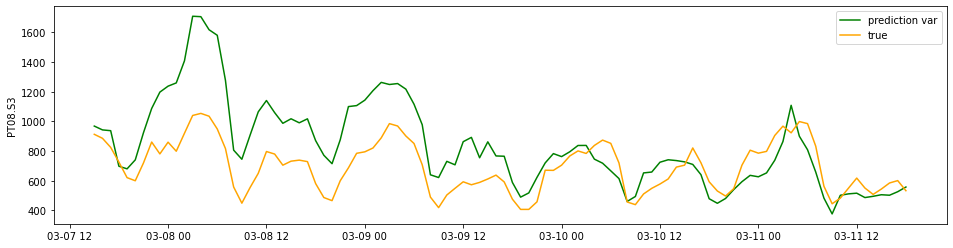

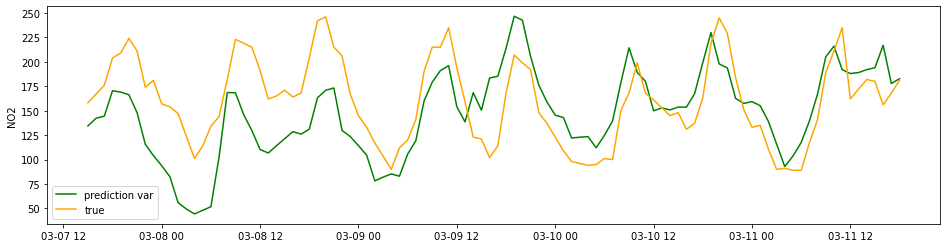

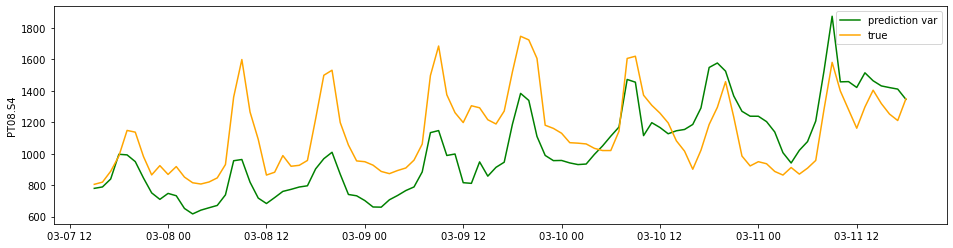

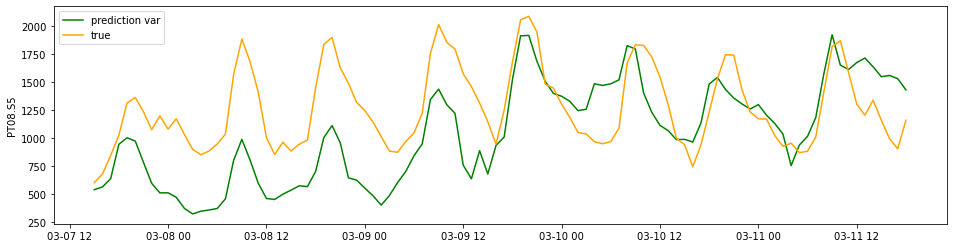

In [23]:
### PLOT ACTUAL vs PREDICTION ###

for i,col in enumerate(df.columns):

    plt.figure(figsize=(16,4))
    plt.plot(date_range, final_pred[:,i], c='green', label='prediction var')
    plt.plot(date_range, final_true[col].values, c='orange', label='true')
    plt.ylabel(col); plt.legend()
    plt.show()

# COMBINE VAR AND LSTM

In [24]:
### UTILITY FUNCTIONS FOR NEURAL NETWORK TRAINING ###

def set_seed_TF2(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def autocor_pred(real, pred, lag=1):
    return stats.pearsonr(real[:-lag], pred[lag:])[0]


def get_model(param, seq_length):
    
    opt_choices = {'adam': Adam(),
                   'nadam': Nadam()}
    
    opt = opt_choices[param['opt']]
    opt.lr = param['lr']
        
    inp = Input(shape=(seq_length, 18))
    
    x = LSTM(param['units_lstm'], activation='tanh')(inp)
    x = Dense(param['units_dense'], activation='relu')(x)
    
    out = Dense(9)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=opt, loss='mse')
    
    return model


def get_model_finetune(param, krs, seq_length):
    
    opt_choices = {'adam': Adam(),
                   'nadam': Nadam()}
    
    opt = opt_choices[param['opt']]
    opt.lr = param['lr']
    
    best_model_config = get_model(krs.best_params, seq_length)
    best_model_config.set_weights(krs.best_model.get_weights())
    
    best_model_config.optimizer = opt
    
    return best_model_config

In [25]:
### DEFINE GRIDS FOR HYPERPARAM TUNING ###

param_grid = {
    'units_lstm': stats.randint(32, 128), 
    'units_dense': stats.randint(32, 128),
    'opt': ['adam', 'nadam'],
    'lr': stats.uniform(1e-4, 0.06), 
    'epochs': 200
}

param_grid_finetune = {
    'opt': ['adam', 'nadam'],
    'lr': stats.loguniform(1e-4, 0.1), 
    'epochs': 200 
}

In [26]:
### GET TRAIN VALIDATION AND TEST DATA FOR NEURAL NETWORK ###

y_train = train.iloc[period+best_order:].values
y_train_var = var_result.fittedvalues + train_init.iloc[best_order:].values

X_train = np.concatenate([train_diff.iloc[best_order:].values, 
                          train_ext.iloc[best_order:].values], axis=1)
X_train_var = np.concatenate([var_result.fittedvalues, 
                              train_ext.iloc[best_order:].values], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  shuffle=False, train_size=0.8)
X_train_var, X_val_var, y_train_var, y_val_var = train_test_split(X_train_var, y_train_var, 
                                                                  shuffle=False, train_size=0.8)

y_test = test.values
X_test = np.concatenate([test_diff.values, test_ext.values], axis=1)

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_var.shape, X_val_var.shape)

print(y_train.shape, y_val.shape, y_test.shape)
print(y_train_var.shape, y_val_var.shape)

(5831, 18) (1458, 18) (1872, 18)
(5831, 18) (1458, 18)
(5831, 9) (1458, 9) (1872, 9)
(5831, 9) (1458, 9)


In [27]:
### SCALE DATA ###

scaler_y = StandardScaler()
scaler = StandardScaler()

y_train = scaler_y.fit_transform(y_train)
y_train_var = scaler_y.transform(y_train_var)
y_val = scaler_y.transform(y_val)
y_val_var = scaler_y.transform(y_val_var)
y_test = scaler_y.transform(y_test)

X_train = scaler.fit_transform(X_train)
X_train_var = scaler.transform(X_train_var)
X_val = scaler.transform(X_val)
X_val_var = scaler.transform(X_val_var)
X_test = scaler.transform(X_test)

In [28]:
### BUILD DATA GENERATOR ###

seq_length = 30
batch_size = 512

generator_train = TimeseriesGenerator(X_train, y_train, length=seq_length, batch_size=batch_size)
generator_train_var = TimeseriesGenerator(X_train_var, y_train_var, length=seq_length, batch_size=batch_size)
generator_val = TimeseriesGenerator(X_val, y_val, length=seq_length, batch_size=batch_size)
generator_val_var = TimeseriesGenerator(X_val_var, y_val_var, length=seq_length, batch_size=batch_size)
generator_test = TimeseriesGenerator(X_test, y_test, length=seq_length, batch_size=batch_size)

In [29]:
### FIT WITH HYPERPARAM TUNING ON VAR FITTED VALUES ###

es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model(param=x, seq_length=seq_length)  

krs_var = KerasRandomSearch(hypermodel, param_grid, n_iter=20, sampling_seed=33,
                        monitor='val_loss', greater_is_better=False, tuner_verbose=1)
krs_var.set_seed(set_seed_TF2, seed=33)
krs_var.search(generator_train_var, None, validation_data=generator_val_var, 
               callbacks=[es], steps_per_epoch= len(generator_train_var))


20 trials detected for ('units_lstm', 'units_dense', 'opt', 'lr', 'epochs')

***** (1/20) *****
Search({'units_lstm': 44, 'units_dense': 127, 'opt': 'nadam', 'lr': 0.03505838112416364, 'epochs': 200})
SCORE: 1.01089 at epoch 25

***** (2/20) *****
Search({'units_lstm': 95, 'units_dense': 121, 'opt': 'adam', 'lr': 0.04954033258693945, 'epochs': 200})
SCORE: 1.08308 at epoch 19

***** (3/20) *****
Search({'units_lstm': 71, 'units_dense': 32, 'opt': 'nadam', 'lr': 0.030695702593747706, 'epochs': 200})
SCORE: 0.97448 at epoch 10

***** (4/20) *****
Search({'units_lstm': 95, 'units_dense': 44, 'opt': 'adam', 'lr': 0.05421194771758986, 'epochs': 200})
SCORE: 1.01087 at epoch 12

***** (5/20) *****
Search({'units_lstm': 125, 'units_dense': 44, 'opt': 'nadam', 'lr': 0.03658222222553413, 'epochs': 200})
SCORE: 1.04541 at epoch 10

***** (6/20) *****
Search({'units_lstm': 105, 'units_dense': 69, 'opt': 'adam', 'lr': 0.02810584856449275, 'epochs': 200})
SCORE: 0.9874 at epoch 19

***** (7/20) **

In [ ]:
### FIT WITH HYPERPARAM TUNING ON RAW VALUES (AFTER THE TRAIN ON VAR FITTED VALUES) ###

es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model_finetune(param=x, krs=krs_var, seq_length=seq_length)  

krs_ft = KerasRandomSearch(hypermodel, param_grid_finetune, n_iter=20, sampling_seed=33,
                        monitor='val_loss', greater_is_better=False, tuner_verbose=1)
krs_ft.set_seed(set_seed_TF2, seed=33)
krs_ft.search(generator_train, None, validation_data=generator_val, 
              callbacks=[es], steps_per_epoch= len(generator_train))


20 trials detected for ('opt', 'lr', 'epochs')

***** (1/20) *****
Search({'opt': 'nadam', 'lr': 0.0035578929912643198, 'epochs': 200})
SCORE: 0.77886 at epoch 5

***** (2/20) *****
Search({'opt': 'adam', 'lr': 0.0957720521140553, 'epochs': 200})
SCORE: 1.62399 at epoch 11

***** (3/20) *****
Search({'opt': 'nadam', 'lr': 0.0012121047654670312, 'epochs': 200})
SCORE: 0.84701 at epoch 7

***** (4/20) *****
Search({'opt': 'adam', 'lr': 0.012470147071703233, 'epochs': 200})
SCORE: 0.83212 at epoch 12

***** (5/20) *****
Search({'opt': 'nadam', 'lr': 0.00572946983435225, 'epochs': 200})
SCORE: 0.82067 at epoch 8

***** (6/20) *****
Search({'opt': 'adam', 'lr': 0.00591782342649118, 'epochs': 200})
SCORE: 0.85202 at epoch 10

***** (7/20) *****
Search({'opt': 'adam', 'lr': 0.003348231036242121, 'epochs': 200})
SCORE: 0.86297 at epoch 4

***** (8/20) *****
Search({'opt': 'nadam', 'lr': 0.0023333093559445585, 'epochs': 200})
SCORE: 0.80883 at epoch 5

***** (9/20) *****
Search({'opt': 'adam',

In [ ]:
### OBTAIN PREDICTIONS AND RETRIVE ORIGINAL DATA ###

true = scaler_y.inverse_transform(y_test[seq_length:])

pred_lstm_var = krs_ft.best_model.predict(generator_test)
pred_lstm_var = scaler_y.inverse_transform(pred_lstm_var)

In [ ]:
### FIT WITH HYPERPARAM TUNING ON VAR FITTED VALUES ###

es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model(param=x, seq_length=seq_length)  

krs = KerasRandomSearch(hypermodel, param_grid, n_iter=20, sampling_seed=33,
                        monitor='val_loss', greater_is_better=False, tuner_verbose=1)
krs.set_seed(set_seed_TF2, seed=33)
krs.search(generator_train, None, validation_data=generator_val, 
           callbacks=[es], steps_per_epoch= len(generator_train))

In [ ]:
### OBTAIN PREDICTIONS ###

pred_lstm = krs.best_model.predict(generator_test)
pred_lstm = scaler_y.inverse_transform(pred_lstm)

In [ ]:
### COMPUTE METRICS ON TEST DATA ###

diz_error_lstm, diz_ac_lstm = {}, {}
diz_error_var_lstm, diz_ac_var_lstm = {}, {}


for i,col in enumerate(df.columns):
    
    error = mean_absolute_error(true[:,i], pred_lstm[:,i])
    diz_error_lstm[col] = error
    
    error = mean_absolute_error(true[:,i], pred_lstm_var[:,i])
    diz_error_var_lstm[col] = error
    
    ac = autocor_pred(true[:,i], pred_lstm[:,i])
    diz_ac_lstm[col] = ac
    
    ac = autocor_pred(true[:,i], pred_lstm_var[:,i])
    diz_ac_var_lstm[col] = ac

In [ ]:
plt.figure(figsize=(14,5))
plt.bar(np.arange(len(diz_error_lstm))-0.15, diz_error_lstm.values(), alpha=0.5, width=0.3, label='lstm')
plt.bar(np.arange(len(diz_error_var_lstm))+0.15, diz_error_var_lstm.values(), alpha=0.5, width=0.3, label='var_lstm')
plt.xticks(range(len(diz_error_lstm)), diz_error_lstm.keys())
plt.ylabel('error'); plt.legend()
np.set_printoptions(False)

In [ ]:
plt.figure(figsize=(14,5))
plt.bar(np.arange(len(diz_ac_lstm))-0.15, diz_ac_lstm.values(), alpha=0.5, width=0.3, label='lstm')
plt.bar(np.arange(len(diz_ac_var_lstm))+0.15, diz_ac_var_lstm.values(), alpha=0.5, width=0.3, label='var_lstm')
plt.xticks(range(len(diz_ac_lstm)), diz_ac_lstm.keys())
plt.ylabel('correlation lag1'); plt.legend()
np.set_printoptions(False)